In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import time
import os
from IPython.display import clear_output

dir_path = os.getcwd()
dir_path = os.path.dirname(dir_path)

sys.path.append(dir_path)

from a3c.ActorCritic import ActorCritic
from dark_room import DarkRoom
from gpt.GPT import GPT
from gpt.Tokenizer import Tokenizer

In [6]:
env = DarkRoom(size=15)
input_dim = env.observation_space.shape[0]
action_space = env.action_space.n


def render_env(env, speepTime=0):
    # clear previous image
    clear_output(wait=True)
    plt.imshow(env.render())
    # plt.axis("off")
    plt.show()
    time.sleep(speepTime)

#### ActorCritic

In [3]:
a3c = ActorCritic(input_dim, action_space)
# load the model
a3c.load_state_dict(torch.load("../models/a3c_model.pth", weights_only=False))

<All keys matched successfully>

In [199]:
def a3c_step(state):
    policy, _ = a3c(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    action = torch.softmax(policy, dim=-1).argmax().item()
    return action


state = env.reset(use_random_agent_pos=True)

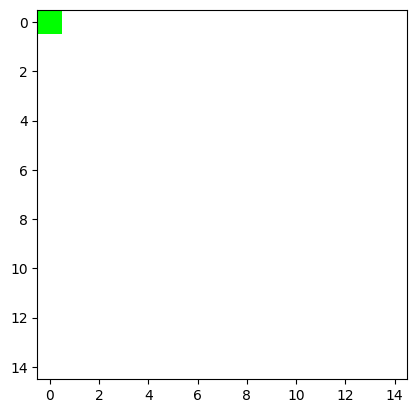

In [208]:
action = a3c_step(state)
state, reward, done = env.step(action)
render_env(env)

#### GPT

In [217]:
gpt = GPT()
gpt.load_state_dict(torch.load("../models/gpt_model.pth", weights_only=False))
gpt.eval()
gpt.cpu()

tokenizer = Tokenizer()
state = env.reset()
history = [[state[0], state[1], 0, 0]]

In [255]:
def gpt_step(action_history):
    if len(action_history) > CFG.block_size // 4 - 1:
        action_history = action_history[-(CFG.block_size // 4 - 1) :]
    tokenized = torch.tensor(
        [tokenizer(action_history)], dtype=torch.long, device="cpu"
    )
    logits, _ = gpt(tokenized)
    action = torch.argmax(logits, dim=1).item()
    return action

In [256]:
action = gpt_step(context)

padding error


IndexError: index out of range in self

In [254]:
len(context[-(CFG.block_size // 4) :])

128

In [237]:
CFG.block_size // 4

128

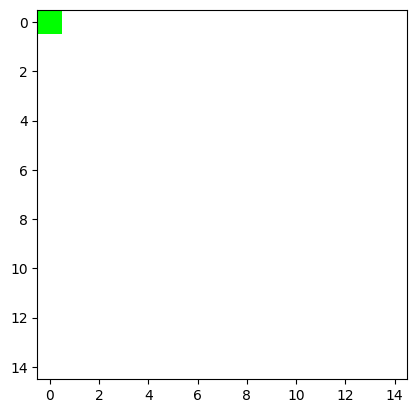

In [233]:
action = gpt_step(history)
state, reward, done = env.step(action)
history.append([state[0], state[1], action, reward])
render_env(env)

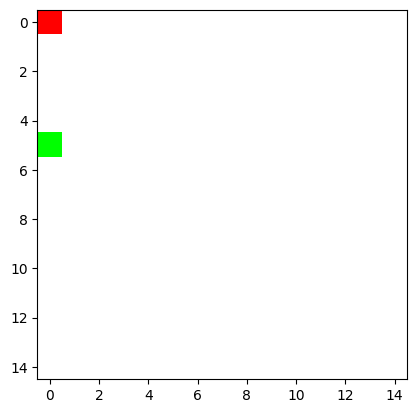

padding error


IndexError: index out of range in self

In [234]:
from gpt.config import CFG


context = []
returns = []
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset(use_random_agent_pos=True)
    if len(context) == 0:
        context = [[state[0], state[1], 0, 0]]
    done = False
    total_return = 0
    while not done:
        # if len(context) > CFG.block_size // 4:
        #     context = context[-(CFG.block_size // 4) :]
        action = gpt_step(context)
        state, reward, done = env.step(action)
        context.append([state[0], state[1], action, reward])
        state, reward, done = env.step(action)
        total_return += reward
        render_env(env, 0.1)
    returns.append(total_return)

In [235]:
context

[[11, 2, 0, 0],
 [10, 2, 2, -1],
 [8, 2, 2, -1],
 [6, 2, 2, -1],
 [5, 1, 0, -1],
 [4, 0, 2, -1],
 [2, 0, 2, -1],
 [0, 0, 2, 1],
 [7, 8, 2, -1],
 [5, 8, 2, -1],
 [4, 7, 0, -1],
 [4, 5, 0, -1],
 [4, 3, 0, -1],
 [4, 1, 0, -1],
 [3, 0, 2, -1],
 [1, 0, 2, -1],
 [9, 5, 0, -1],
 [9, 3, 0, -1],
 [9, 1, 0, -1],
 [9, 0, 0, -1],
 [8, 0, 2, -1],
 [6, 0, 2, -1],
 [4, 0, 2, -1],
 [2, 0, 2, -1],
 [0, 0, 2, 1],
 [12, 1, 0, -1],
 [12, 0, 0, -1],
 [12, 0, 0, -1],
 [12, 0, 0, -1],
 [11, 0, 2, -1],
 [9, 0, 2, -1],
 [7, 0, 2, -1],
 [5, 0, 2, -1],
 [3, 0, 2, -1],
 [1, 0, 2, -1],
 [12, 12, 2, -1],
 [10, 12, 2, -1],
 [9, 11, 0, -1],
 [9, 9, 0, -1],
 [9, 7, 0, -1],
 [9, 5, 0, -1],
 [9, 3, 0, -1],
 [9, 1, 0, -1],
 [9, 0, 0, -1],
 [9, 0, 0, -1],
 [8, 0, 2, -1],
 [6, 0, 2, -1],
 [4, 0, 2, -1],
 [2, 0, 2, -1],
 [0, 0, 2, 1],
 [5, 3, 0, -1],
 [5, 1, 0, -1],
 [5, 0, 0, -1],
 [5, 0, 0, -1],
 [5, 0, 0, -1],
 [4, 0, 2, -1],
 [2, 0, 2, -1],
 [0, 0, 2, 1],
 [4, 11, 0, -1],
 [4, 9, 0, -1],
 [4, 7, 0, -1],
 [4, 5, 0, -1],


In [213]:
returns

[-4,
 -10,
 -8,
 -3,
 -5,
 -11,
 -3,
 -7,
 -3,
 -2,
 -11,
 -6,
 1,
 -8,
 0,
 -1,
 -2,
 -7,
 -11,
 -6,
 -7,
 -9,
 -10,
 -5,
 -1,
 -8,
 -5,
 -3,
 -7,
 -6,
 -9,
 -11,
 -8,
 -7,
 -4,
 1,
 -7,
 -9,
 -3,
 -3,
 -11,
 -8,
 -5,
 -6,
 -7,
 -4,
 -1,
 -2,
 -4,
 -5,
 1,
 -9,
 -8,
 -5,
 -3,
 -9,
 -11,
 -4,
 -1,
 -2,
 -8,
 -1,
 -7,
 -11,
 -11,
 -8,
 -7,
 -7,
 -3,
 -9,
 -5,
 0,
 0,
 -3,
 -7,
 -4,
 -5,
 -11,
 -7,
 -7,
 -3,
 -7,
 -6,
 -11,
 -11,
 -8,
 -4,
 -5,
 -9,
 -5,
 -10,
 -3,
 -8,
 -5,
 -8,
 -2,
 -5,
 -4,
 -5,
 -4]

In [ ]:
def evaluate_ad_model(model, env, num_episodes=1000, context_size=200):

    for episode in range(num_episodes):
        obs = env.reset()  # Reset environment, but don't clear context
        episode_return = 0

        for step in range(50):  # 50 steps per episode
            if len(context) >= context_size:
                context = context[-context_size:]

            action = model.predict(context + [obs])
            next_obs, reward, done, _ = env.step(action)

            context.append((obs, action, reward))
            episode_return += reward
            obs = next_obs

            if done:
                break

        returns.append(episode_return)

    return returns

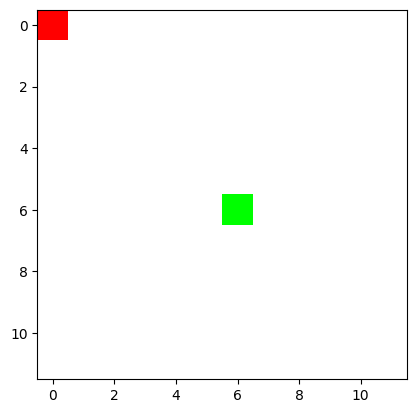

In [7]:
grid_to_render = env.render()


plt.imshow(grid_to_render)
plt.show()